In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
page = requests.get('https://www.tu-bryansk.ru/abiturient/cpage/625.htm?filter=y')

In [3]:
page.status_code

200

In [4]:
soup = BeautifulSoup(page.content, 'html.parser', from_encoding='UTF-8')

In [10]:
script_blocks = soup.find_all('script', {'type': 'text/javascript'})

raw_data = script_blocks[16].get_text().strip()
raw_data = raw_data[raw_data.find('{'): raw_data.find('var abits')-6]
raw_data = raw_data.split('id')[1:]

In [6]:
def decode_str(s):
    try:
        s = re.sub('u', '\\\\u', s).encode('utf8').decode('unicode-escape').encode('utf-8').decode('utf8') \
        if re.search('u[a-f0-9]{3}', s) is not None else s
        return s    
    except TypeError:
        return s

In [61]:
df = pd.DataFrame()

for data in tqdm(raw_data):
    s = re.sub('\\\\', '', data)
    
    id = re.match('\D*\d*', s).group().split(':"')[1]
    snils = re.search('"snils":".*?"', s).group().split(':')[1].strip('"')
    date = re.search('"date":".*?"', s).group().split('":')[1].strip('"')
    first_name = re.search('"firstName":".*?"', s).group().split(':')[1].strip('"')
    last_name = re.search('"lastName":".*?"', s).group().split(':')[1].strip('"')
    second_name = re.search('"secondName":".*?"', s)
    second_name = second_name.group().split(':')[1].strip('"') if second_name is not None else ''
       
    substr = re.findall('\{"declaration":.*?\}', s)
    details = []
    
    for ss in substr:
        declaration = re.search('"declaration":".*?"', ss).group().split(':')[1].strip('"')
        code = re.search('"code":".*?"', ss).group().split(':')[1].strip('"')
        title = re.search('"title":".*?"', ss).group().split(':')[1].strip('"')
        forma = re.search('"forma":".*?"', ss).group().split(':')[1].strip('"')
        level = re.search('"level":".*?"', ss).group().split(':')[1].strip('"')
        budget = re.search('"budget":".*?"', ss).group().split(':')[1].strip('"')
        category = re.search('"category":".*?"', ss).group().split(':')[1].strip('"')
        scores = re.search('"scores":\d*', ss).group().split(':')[1].strip('"')
        details.append([declaration, code, title, forma, level, budget, category, scores])
    
    priority = re.search('"priority":\d*', s).group().split(':')[1].strip('"')
    qualif = re.search('"qualif":".*?"', s).group().split(':')[1].strip('"')
    original = re.search('"original":"[YN]"', s).group().split(':')[1].strip('"')
    statement = re.search('"statement":"[YN]"', s).group().split(':')[1].strip('"')

    russian = re.search('"scoresRussian":"[0-9-]*"', s).group().split(':')[1].strip('"')
    math = re.search('"scoresMath":"[0-9-]*"', s).group().split(':')[1].strip('"')
    physics = re.search('"scoresPhysics":"[0-9-]*"', s).group().split(':')[1].strip('"')
    inform = re.search('"scoresInform":"[0-9-]*"', s).group().split(':')[1].strip('"')
    social = re.search('"scoresSocial":"[0-9-]*"', s).group().split(':')[1].strip('"')
    lang = re.search('"scoresLang":"[0-9-]*"', s).group().split(':')[1].strip('"')
    chemistry = re.search('"scoresChemistry":"[0-9-]*"', s).group().split(':')[1].strip('"')
    mathspo = re.search('"scoresAppMathSPO":"[0-9-]*"', s).group().split(':')[1].strip('"')
    informspo = re.search('"scoresAppInformSPO":"[0-9-]*"', s).group().split(':')[1].strip('"')
    mechanicsspo = re.search('"scoresMechanicsSPO":"[0-9-]*"', s).group().split(':')[1].strip('"')
    electrospo = re.search('"scoresElectroSPO":"[0-9-]*"', s).group().split(':')[1].strip('"')
    economicspo = re.search('"scoresEconomicSPO":"[0-9-]*"', s).group().split(':')[1].strip('"')
    bonus = re.search('"scoresBonus":"[0-9-]*"', s).group().split(':')[1].strip('"')
        
    out  = pd.Series([id, snils, date,  last_name, first_name, second_name, details, 
                      priority, qualif, original, statement, 
                      russian, math, physics, inform, social, lang, chemistry, 
                      mathspo, informspo, mechanicsspo, electrospo, economicspo, 
                      bonus])
    
    df = pd.concat([df, out], axis=1)

df = df.rename({
    0: 'id', 1: 'snils', 2: 'date', 3: 'last_name', 4: 'first_name', 5: 'second_name', 6: 'details', 
    7: 'priority', 8: 'qualif', 9: 'paper', 10: 'statement', 
    11: 'russian', 12: 'math', 13: 'physics', 14: 'inform', 15: 'social', 16: 'lang', 17: 'chemistry',
    18: 'mathspo', 19: 'informspo', 20: 'mechanicsspo', 21: 'electrospo', 22: 'economicspo', 
    23: 'bonus'})\
.transpose()\
.applymap(decode_str)\
.assign(details=lambda x: x.details.apply(
    lambda details: [[decode_str(i) for i in declaration] for declaration in details])
)\
.replace({'Y': True, 'N': False, '-': None})

100%|███████████████████████████████████████████████████████████████████████████████████████| 3040/3040 [00:52<00:00, 57.82it/s]


In [62]:
df = df\
.merge(pd.concat([pd.DataFrame(lst).assign(id=df.id.values[id]).reset_index()\
                  for id, lst in enumerate(df.details.values)], axis=0)\
       .rename(columns={'index': 'profile_rank', 0: 'declaration', 1: 'code', 2: 'profile', 
                        3: 'forma', 4: 'level', 5: 'budget', 6: 'category', 7: 'scores'}))\
.drop('details', axis=1)\
.assign(profile_code=lambda x: x.profile.apply(lambda y: y.strip().split(' ')[0]), 
        profile_name=lambda x: x.code.apply(lambda y: y.split('_')[0]))

In [222]:
data = df\
.replace({'budget': {'Бюджетная основа': 'Бюджет',
                     'Полное возмещение затрат': 'Платно',
                     'Целевой прием': 'Целевое'}, 
          'level': {'Подготовка кадров высшей квалификации': 'Аспирантура'},
          'paper': {True: 'Оригинал', False: 'Копия'}
})\
.groupby(['profile_code', 'profile_name', 'forma', 'level', 'budget', 'category', 'paper'], as_index=False)\
.agg(total_sbm=('id', 'count'), 
     fst_pf=('profile_rank', lambda x: np.sum(x == 0)),
     snd_pf=('profile_rank', lambda x: np.sum(x == 1)),
     thd_pf=('profile_rank', lambda x: np.sum(x == 2)), 
)

In [223]:
data.sample(5)

,profile_code,profile_name,forma,level,budget,category,paper,total_sbm,fst_pf,snd_pf,thd_pf
319,2.4.7.,ТиПД,Очная,Аспирантура,Платно,по конкурсу,Оригинал,8,0,8,0
165,13.03.03,ЭМ(ПГУ),Очная,Бакалавр,Бюджет,по конкурсу,Оригинал,95,22,14,20
378,23.05.03,ПСЖД(ЛОК),Очная,Специалист,Бюджет,вне конкурса,Копия,1,0,0,1
43,09.03.02,ИСТ(ИТПК),Очная,Бакалавр,Платно,по конкурсу,Копия,11,1,2,2
338,20.03.01,ТБ(БТП),Заочная,Бакалавр,Платно,по конкурсу,Копия,9,4,2,2


In [243]:
data_long = pd.melt(
    data.query('forma == "Очная" & level == "Бакалавр"')\
    .groupby(['profile_code', 'profile_name'], as_index=False)\
    .agg(fst_pf=('fst_pf', 'sum'), 
         snd_pf=('snd_pf', 'sum'), 
         thd_pf=('thd_pf', 'sum'))\
    .reset_index(),
    id_vars=['profile_code', 'profile_name'], value_vars=['fst_pf', 'snd_pf', 'thd_pf'],
    var_name='profile_rank', value_name='count'
)\
.replace({'profile_rank': {'fst_pf': 1, 'snd_pf': 2, 'thd_pf': 3}})

In [244]:
import plotly.express as px

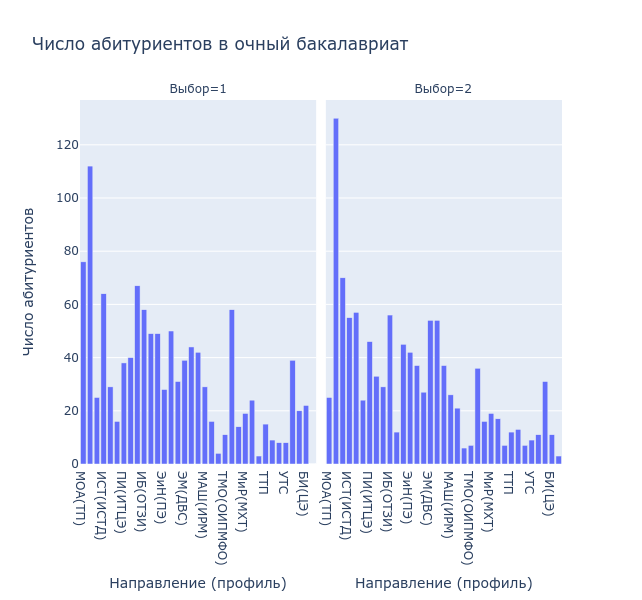

In [245]:
px.bar(
    data_long.query('profile_rank < 3'), y='count', x='profile_name', facet_col='profile_rank', barmode='group', 
    width=1000, height=600, 
    labels={'profile_name': 'Направление (профиль)', 
            'count': 'Число абитуриентов', 'profile_rank': 'Выбор'},
    title='Число абитуриентов в очный бакалавриат',
)

In [246]:
code_dict = {}

for profile in df.profile.drop_duplicates():
    try:
        code = re.search('\d*.\d*.\d*', profile).group()
        name = re.search('\d{2} .*? \\(', profile).group()[3:-2]
        if code not in code_dict:
            code_dict[code] = name
    except AttributeError:
        continue

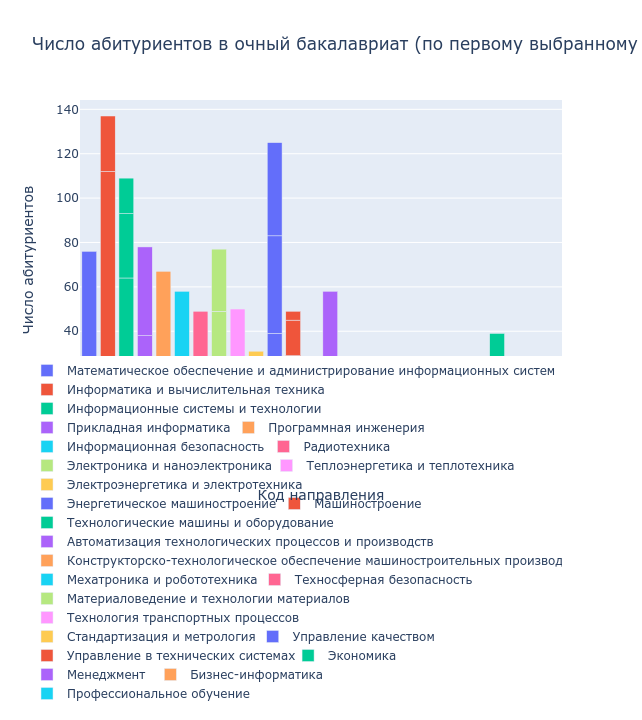

In [250]:
fig = px.bar(data_long\
       .assign(profile_fullname = lambda x: x.profile_code.apply(lambda y: code_dict[y]))\
       .query('profile_rank == 1'), y='count', x='profile_code', color='profile_fullname', 
    width=1000, height=720, 
    labels={'profile_code': 'Код направления', 
            'profile_fullname': 'Направление',
            'count': 'Число абитуриентов', 'profile_rank': 'Выбор'},
    title='Число абитуриентов в очный бакалавриат (по первому выбранному профилю)',
)
fig.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=-0.9, xanchor="right", x=1),
    legend_title_text=''
)
fig.show()